# Recommendation example

In this notebook we will demonstrate how to compute a recommendation given some data and the weighted hypervolume.

## Initialize a problem

We will initialize the ZDT1 benchmark with two-dimensional inputs and outputs.

In [1]:
import torch
from botorch.utils.sampling import draw_sobol_samples
from botorch.test_functions.multi_objective import ZDT1

In [2]:
d = 2
M = 2
n = 6

problem = ZDT1(dim=d, num_objectives=M, noise_std=0, negate=True)
bounds = problem.bounds

# `n x d`
train_X = draw_sobol_samples(bounds=bounds, n=n, q=1, seed=123).squeeze(-2)
train_Y = problem(train_X)

## Get recommendation

To obtain the recommendation, we optimize the posterior mean using a multi-objective solver (NSGA2 from pymoo). We oversample the Pareto set and truncate using a greedy hypervolume truncation strategy.

In [3]:
from jes.utils.performance import get_recommendation

In [4]:
ps, pf = get_recommendation(
    train_X=train_X,
    train_Y=train_Y,
    bounds=bounds,
    num_samples=50,
    n_initial=n,
    seed=123,
) 

n =   1/  1, Time taken= 6.95


## Plot

In [5]:
import matplotlib.pyplot as plt

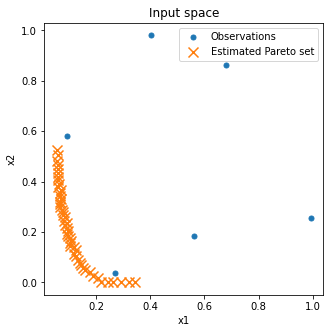

In [6]:
fig = plt.figure(figsize=(5, 5))
plt.scatter(train_X[:, 0], train_X[:, 1], marker=".", s=100, label="Observations")
plt.scatter(ps[0, :, 0], ps[0, :, 1], marker="x", s=100, label="Estimated Pareto set")

plt.xlabel("x1")
plt.ylabel("x2")
plt.title("Input space")
plt.legend()
plt.show()

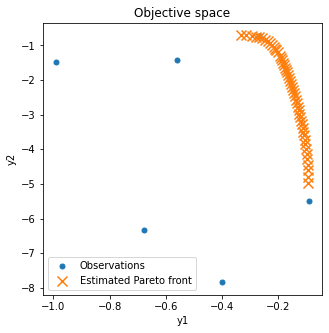

In [7]:
fig = plt.figure(figsize=(5, 5))
plt.scatter(train_Y[:, 0], train_Y[:, 1], marker=".", s=100, label="Observations")
plt.scatter(pf[0, :, 0], pf[0, :, 1], marker="x", s=100, label="Estimated Pareto front")

plt.xlabel("y1")
plt.ylabel("y2")
plt.title("Objective space")
plt.legend()
plt.show()

## Compute the weighted hypervolume

We now compute the weighted hypervolume using different Beta distributions.

In [8]:
from jes.utils.performance import get_beta_distributions
import numpy as np
from scipy.stats import beta

In [9]:
alphas, betas = get_beta_distributions(10)

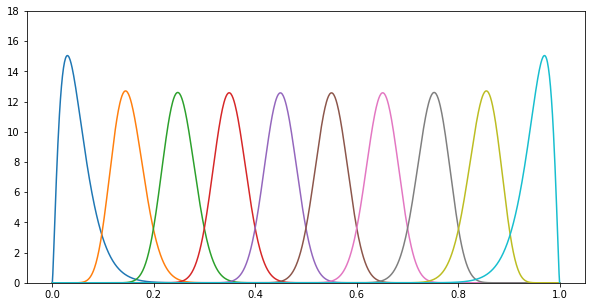

In [10]:
t = np.linspace(0, 1, 1000)
fig = plt.figure(figsize=(10, 5))
for i in range(len(alphas)):
    beta_i = beta(alphas[i], betas[i])
    plt.plot(t, beta_i.pdf(t))
plt.ylim([0, 18])
plt.show()

In [11]:
import itertools
from jes.utils.performance import compute_ghv
import time

In [12]:
init_time = time.time()
indices = np.arange(len(alphas))
iterator = [p for p in itertools.product(indices, repeat=M-1)]
ghv = torch.zeros(len(iterator))

for j in range(len(iterator)):
    idx = iterator[j]
    a = [alphas[idx]]
    b = [betas[idx]]
    
    ghv_j = compute_ghv(
        a=a, 
        b=b, 
        pf=pf.squeeze(0), 
        ref_point=problem.ref_point, 
        num_mc_samples = 2**10,
        seed=123
    )
    ghv[j] = ghv_j
print("Time taken = {:4.2f}".format(time.time() - init_time))

Time taken = 0.06


In [13]:
ghv

tensor([ 94.2537,  99.1085, 109.8787, 128.9740, 157.9267, 144.6188, 114.9378,
         97.7466,  88.1660,  83.8463])

## Estimating the standard hypervolume

Here we do a sanity check by comparing the Monte Carlo estimate of the standard hypervolume with the exact value. The weight distribution for the standard hypervolume assumes a uniform distribution, which is a Beta(1, 1).

In [14]:
hv_est = compute_ghv(
    a=[1.0], 
    b=[1.0], 
    pf=pf.squeeze(0), 
    ref_point=problem.ref_point, 
    num_mc_samples = 2**10,
    seed=123
)
print(hv_est)

111.98772089055383


In [15]:
from botorch.utils.multi_objective import Hypervolume

In [16]:
hv = Hypervolume(problem.ref_point)
hv_exact = hv.compute(pf.squeeze(0))
print(hv_exact)

111.98705291748047
